In [1]:
import yaml
import munch

import xarray as xr
import pandas as pd

from tqdm.dask import TqdmCallback
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cmocean import cm as cmo  # registers the cmocean colormaps to matplotlib

In [2]:
datainfo = munch.munchify(
    yaml.load(
        stream=open('../data/data_sources.yaml'), 
        Loader=yaml.FullLoader
        )
    )
datainfo.keys()

dict_keys(['chl_cci', 'chl_globcolour_A', 'chl_globcolour_B', 'soda', 'ssh_duacs_cmems', 'sst_cci_cdr_A', 'sst_cci_cdr_B', 'sst_oisst', 'sss_cci', 'sss_multiobs'])

In [6]:
print(datainfo.keys())
sss_cci = datainfo.sst_cci_cdr_B
sss_cci.variables
print(sss_cci.url)

time = pd.Timestamp('2023-12-09')
forurl = sss_cci.url.split('::')[1].format(t=time)
print(forurl)

dict_keys(['chl_cci', 'chl_globcolour_A', 'chl_globcolour_B', 'soda', 'ssh_duacs_cmems', 'sst_cci_cdr_A', 'sst_cci_cdr_B', 'sst_oisst', 'sss_cci', 'sss_multiobs'])
filecache::https://dap.ceda.ac.uk/neodc/eocis/data/global_and_regional/sea_surface_temperature/CDR_v3/Analysis/L4/v3.0.1/{t:%Y}/{t:%m}/{t:%d}/{t:%Y%m%d}120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_ICDR3.0-v02.0-fv01.0.nc
https://dap.ceda.ac.uk/neodc/eocis/data/global_and_regional/sea_surface_temperature/CDR_v3/Analysis/L4/v3.0.1/2023/12/09/20231209120000-ESACCI-L4_GHRSST-SSTdepth-OSTIA-GLOB_ICDR3.0-v02.0-fv01.0.nc


In [9]:

dataset = xr.open_dataset(
    sss_cci.url.format(t=time),
    chunks={},
    engine='h5netcdf'
    )

In [10]:
dataset

<xarray.Dataset> Size: 415MB
Dimensions:                   (time: 1, bnds: 2, lat: 3600, lon: 7200)
Coordinates:
  * time                      (time) datetime64[ns] 8B 2023-12-09T12:00:00
  * lat                       (lat) float32 14kB -89.97 -89.93 ... 89.93 89.97
  * lon                       (lon) float32 29kB -180.0 -179.9 ... 179.9 180.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds                 (time, bnds) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds                  (lat, bnds) float32 29kB dask.array<chunksize=(3600, 2), meta=np.ndarray>
    lon_bnds                  (lon, bnds) float32 58kB dask.array<chunksize=(7200, 2), meta=np.ndarray>
    analysed_sst              (time, lat, lon) float32 104MB dask.array<chunksize=(1, 900, 1800), meta=np.ndarray>
    analysed_sst_uncertainty  (time, lat, lon) float32 104MB dask.array<chunksize=(1, 900, 1800), meta=np.ndarray>
    sea_ice_fraction          (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    mask                      (time, lat, lon) float32 104MB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
Attributes: (12/66)
    Conventions:                    CF-1.5, Unidata Observation Dataset v1.0
    title:                          ESA SST CCI Analysis v3.0
    summary:                        European Space Agency Sea Surface Tempera...
    references:                     Embury, O. et al. Satellite-based time-se...
    institution:                    ESACCI
    history:                        Created using OSTIA reanalysis system ICD...
    ...                             ...
    processing_level:               L4
    cdm_data_type:                  grid
    product_specification_version:  SST_CCI-PSD-UKMO-201-Issue-2
    key_variables:                  analysed_sst,sea_ice_fraction
    contact:                        https://climate.esa.int/en/projects/sea-s...
    creation_date:                  2024-01-04T10:00:21Z

In [15]:
saldata = dataset.analysed_sst.isel(time=0).compute()
saldata

<xarray.DataArray 'analysed_sst' (lat: 3600, lon: 7200)> Size: 104MB
array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       ...,
       [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
       [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35],
       [271.35, 271.35, 271.35, ..., 271.35, 271.35, 271.35]],
      shape=(3600, 7200), dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 2023-12-09T12:00:00
  * lat      (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * lon      (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    long_name:            analysed sea surface temperature
    standard_name:        sea_water_temperature
    units:                kelvin
    valid_min:            -300
    valid_max:            4500
    actual_range:         [271.15 305.9 ]
    source:               AVHRRMTB-UKEOCIS-L3U-ICDR-v3.0, SLSTRA-UKEOCIS-L3U-...
    depth:                20 cm
    ancillary_variables:  analysed_sst_uncertainty mask

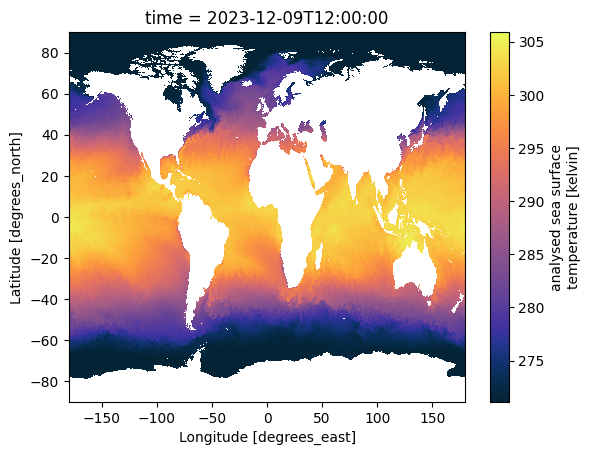

In [16]:
saldata.plot.imshow(cmap='cmo.thermal')

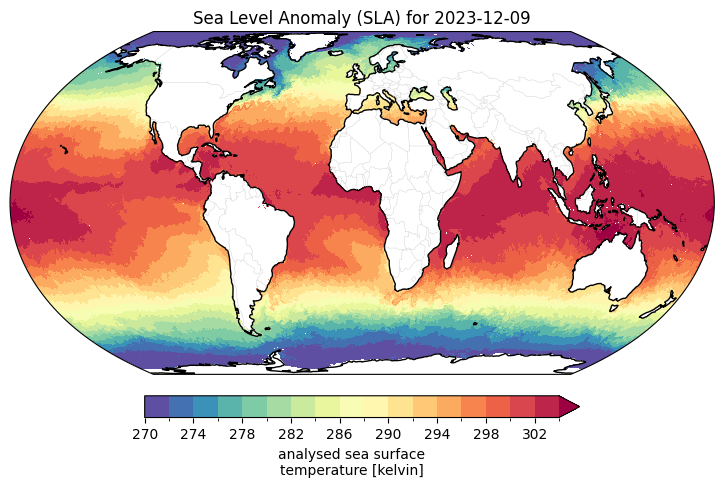

In [18]:
def plot_satmap(da): 
    fig, ax = plt.subplots(
    figsize=(9, 5), 
    subplot_kw=dict(
        projection=ccrs.EqualEarth()  # the map projection we want to use
    ), 
    dpi=100)

    img = (
        da
        .plot.imshow(  # the xarray.DataArray matplotlib API has [imshow, pcolormesh, contour, contourf] methods
            ax=ax,  # plot on the axis we created
            transform=ccrs.PlateCarree(),  # required to transform the data to the map projection (always PlateCarree)
            cmap='Spectral_r',
            levels=20,  # create discrete colorbar (not the same as contourf)
            center=False,  # if true, the colormap is centered on zero
            cbar_kwargs=dict(  # colorbar keyword arguments
                # label='Custom label for SLA [m]',  # we can set the label, but by default will use `da.attrs.long_name [da.attrs.units]` 
                location='bottom', 
                shrink=0.5,  # reduce the colorbar size to fit our plot
                pad=0.05),
            robust=True,  # this will set the colormap limits to the 2nd and 98th percentiles
        )
    )
    
    ax.coastlines(lw=1)  # axes with cartopy projection have a coastlines method
    ax.add_feature(cfeature.BORDERS.with_scale('110m'), edgecolor='0.8', linewidth=0.3)
    ax.set_title(f'Sea Level Anomaly (SLA) for {pd.Timestamp(da.time.values):%Y-%m-%d}')
    
    fig.tight_layout()
    plt.show()

plot_satmap(saldata)